# II. Programming
## Consider the diabetes.arff data available at the homework tab, comprising 8 biological features to classify 768 patients into 2 classes (normal, diabetes). 

In [3]:
# General imports
import pandas as pd
from scipy.io import arff
import plotly.express as px
import matplotlib.pyplot as plt

In [4]:
diabetes_data, diabetes_metadata = arff.loadarff('diabetes.arff')
df = pd.DataFrame(diabetes_data)

In [54]:
diabetes_metadata

Dataset: diabetes
	Pregnancies's type is numeric
	Glucose's type is numeric
	BloodPressure's type is numeric
	SkinThickness's type is numeric
	Insulin's type is numeric
	BMI's type is numeric
	DiabetesPedigreeFunction's type is numeric
	Age's type is numeric
	Outcome's type is nominal, range is ('0', '1')

### Visualizing and preprocessing

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'1'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'0'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'1'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'0'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'1'


In [6]:
df['Outcome'] = df['Outcome'].apply(lambda x: int(x))

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


### 1. [1v] ANOVA is a statistical test that can be used to assess the discriminative power of a single input variable. Using f_classif from sklearn, identify the input variables with the worst and best discriminative power. Plot their class-conditional probability density functions.

In [8]:
# Imports
from sklearn import feature_selection as fs
from scipy.stats import norm
import numpy as np

In [9]:
f_stats, p_values = fs.f_classif(df.drop('Outcome', axis=1), df['Outcome'])

In [10]:
fig = px.scatter(x=df.columns[:-1], y=f_stats, labels={'x': 'Feature', 'y': 'F Statistic', 'color': 'p-values'}, color=p_values, title='F-value for each feature')
fig.update_traces(marker_size=15)

The F Statistic, one of the metrics given by ```f_classif```, is a ratio between the variance between groups and the variance within groups. Essentially, it translates how much of the variance is due to differences between different groups in the data - here, the groups are specified by the target class of each entry/data point.

$$\text{F-value} = \frac{\text{between groups variance}}{\text{within groups variance}}$$

As this is the case, the variable which shows the highest F statistic should hold the largest (and, therefore, best) discriminative power, and vice-versa for the variable with the lowest discriminative power.

We conclude, therefore, that the variable with the...
- **best** discriminative power is ```'Glucose'```, with an F-value of _213.1618_    (p-value: _8.9E-43_).
- **worst** discriminative power is ```'BloodPressure'```, with an F-value of _3.25695_    (p-value: _0.071_).

The higher the p-value, the more confidently we can accept the null hypothesis that the means of the variable are the same across all classes. Here, the p-values further support what the F-values are showing.

In [150]:
# Empirical (unsure whether to do this or to use a gaussian maximum likelihood estimate, since the variables are numerical)

def empirical_pdf_class(variable, df):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f'Empirical PDF for {variable}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Probability')
    for target_val in [0,1]:
        val_color = 'C'+str(target_val)
        data = df[df['Outcome'] == target_val][variable]
        ax.hist(data, bins=int(max(df[variable])), alpha=0.6, density=True, color=val_color, label=target_val)
        mu, std = norm.fit(data)
        inf, sup = min(data), max(data) # x axis limits
        x_vals = np.linspace(inf, sup, 200)
        ax.plot(x_vals, norm.pdf(x_vals, mu, std), color= val_color, alpha = 0.6)
    ax.legend(title='Outcome')
        
    return fig
    

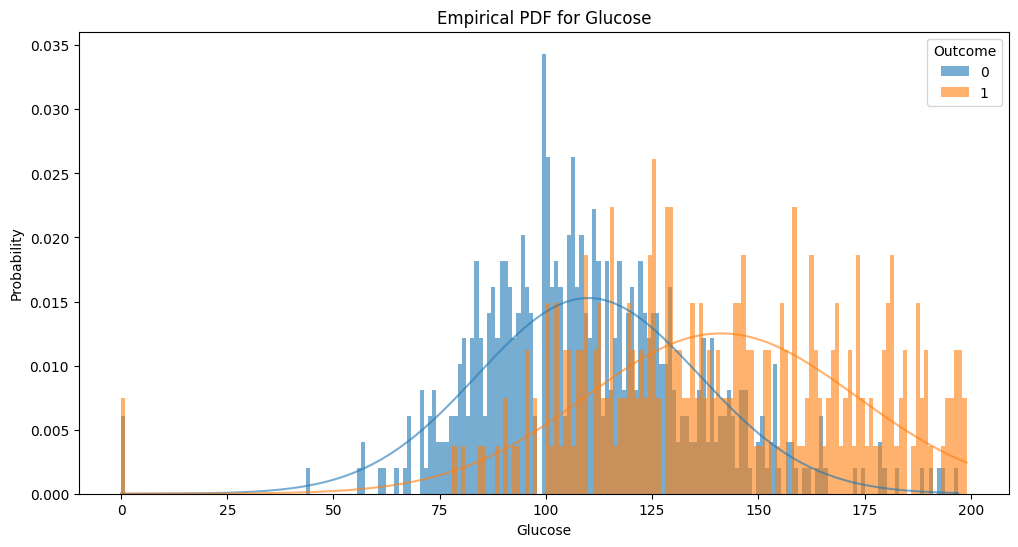

In [151]:
glucose_pdf = empirical_pdf_class('Glucose', df)

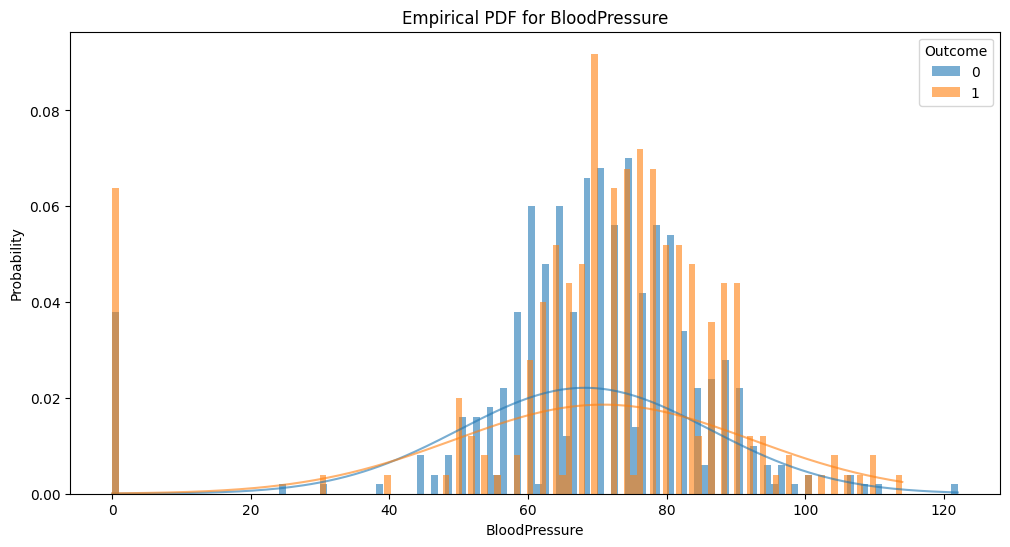

In [152]:
blood_pressure_pdf = empirical_pdf_class('BloodPressure', df)

In [173]:
# Gaussian MLE
def mle_pdf_class(variable, df):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'MLE PDF for {variable}')
    for target_val in [0,1]:
        data = df[df['Outcome'] == target_val][variable]
        mu, std = norm.fit(data)
        inf, sup = min(data), max(data) # x axis limits
        x_vals = np.linspace(inf, sup, 200)
        axs[target_val].plot(x_vals, norm.pdf(x_vals, mu, std))
        axs[target_val].axvline(mu, color='orchid', linestyle='--', label='Mean')
        axs[target_val].annotate(f'μ = {mu:.2f}\nσ = {std:.2f}',
                                 xy=(0,0),
                                 xytext=(0.1,0.2),
                                 xycoords='axes fraction')
        axs[target_val].set_title(f'MLE Gaussian distribution for class {target_val}')
        axs[target_val].set_xlabel(variable)
        axs[target_val].set_ylabel('Probability')
        
    return fig

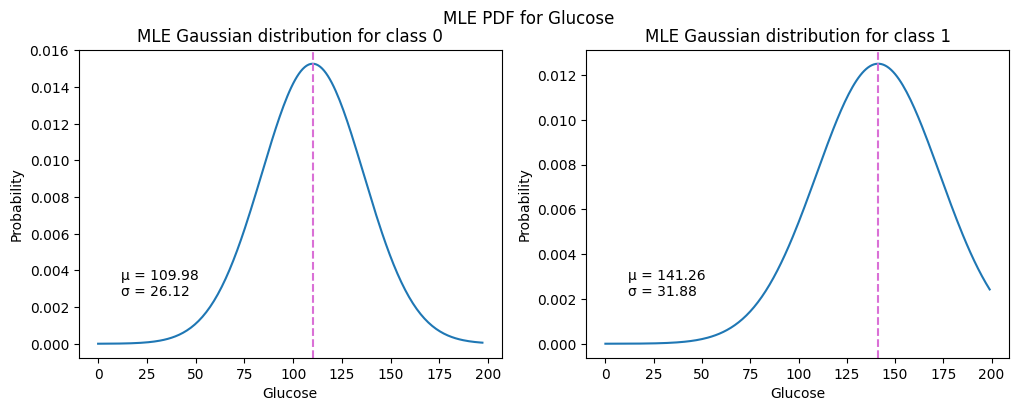

In [174]:
glucose_mle_pdf = mle_pdf_class('Glucose', df)

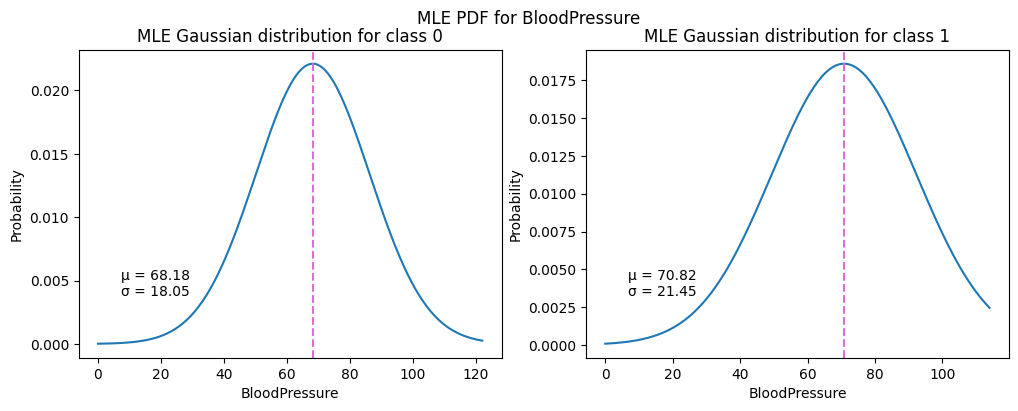

In [175]:
blood_pressure_mle_pdf = mle_pdf_class('BloodPressure', df)

### 2) [4v] Using a stratified 80-20 training-testing split with a fixed seed (random_state=1), assess in a single plot both the training and testing accuracies of a decision tree with minimum sample split in {2,5,10,20,30,50,100} and the remaining parameters as default.  

[optional] Note that split thresholding of numeric variables in decision trees is non-
deterministic in sklearn, hence you may opt to average the results using 10 runs per 
parameterization.

In [59]:
# Imports

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier

In [60]:
# Train-test split

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_inds, test_inds = next(stratified_splitter.split(np.zeros(len(df)), df['Outcome']))


X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train = X.iloc[train_inds]
y_train = y.iloc[train_inds]
X_test = X.iloc[test_inds]
y_test = y.iloc[test_inds]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

[0.6883116883116883, 0.7077922077922078, 0.7077922077922078, 0.7142857142857143, 0.7142857142857143, 0.7012987012987013, 0.7207792207792207, 0.6948051948051948, 0.6948051948051948, 0.7077922077922078]
[0.7142857142857143, 0.6883116883116883, 0.6818181818181818, 0.7142857142857143, 0.6948051948051948, 0.7207792207792207, 0.7077922077922078, 0.7142857142857143, 0.6818181818181818, 0.7012987012987013]
[0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.6948051948051948, 0.6948051948051948, 0.7142857142857143, 0.7077922077922078, 0.7337662337662337, 0.7272727272727273]
[0.7402597402597403, 0.7402597402597403, 0.7597402597402597, 0.7597402597402597, 0.7337662337662337, 0.7337662337662337, 0.7597402597402597, 0.7532467532467533, 0.7337662337662337, 0.7402597402597403]
[0.7467532467532467, 0.7467532467532467, 0.7467532467532467, 0.7467532467532467, 0.7467532467532467, 0.7467532467532467, 0.7662337662337663, 0.7662337662337663, 0.7662337662337663, 0.7467532467532

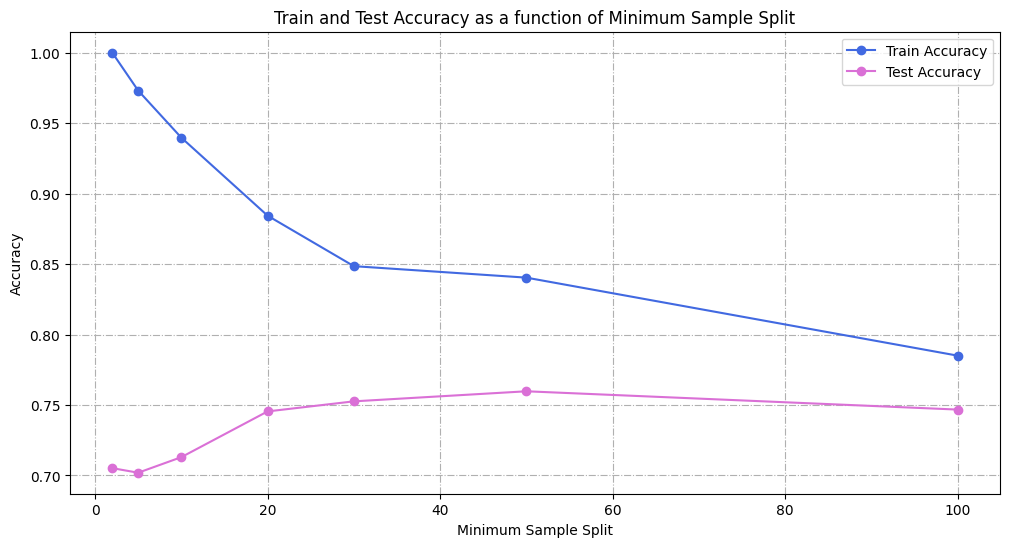

In [70]:
min_sample_splits = [2,5,10,20,30,50,100]
train_accuracies = []
test_accuracies = []

def fitted_tree_classifier(X_train, y_train, min_samples_split):
    tree = DecisionTreeClassifier(min_samples_split=min_samples_split)
    return tree.fit(X_train, y_train)

for min_samples_split in min_sample_splits:
    train_accuracies_temp = []
    test_accuracies_temp = []
    for i in range(10):
        tree = fitted_tree_classifier(X_train, y_train, min_samples_split)
        train_accuracies_temp.append(tree.score(X_train, y_train))
        test_accuracies_temp.append(tree.score(X_test, y_test))
    print(test_accuracies_temp)
    train_accuracies.append(np.mean(train_accuracies_temp))
    test_accuracies.append(np.mean(test_accuracies_temp))

print(train_accuracies)
print(test_accuracies)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(min_sample_splits, train_accuracies, label='Train Accuracy', marker='o', color = 'royalblue')
ax.plot(min_sample_splits, test_accuracies, label='Test Accuracy', marker='o', color = 'orchid')
ax.set_xlabel('Minimum Sample Split')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracy as a function of Minimum Sample Split')
ax.legend()
ax.grid(visible=True, linestyle='-.')
    

### 3) [2v] Critically analyze these results, including the generalization capacity across settings.

We can observe very different behaviours from the train set accuracy results vs the test set accuracy results.

Starting with the train set, there is a clear tendency for very high accuracy in very small minimum sample split, with a steep decrease up to a point (around 30 samples in the split). From this point on, the decrease continues, but it's much less steep.

In the test set, the classifier's accuracy is very low for very small minimum sample split values, followed by a steep increase up to around 30 samples split and a small increase up to the 50 sample mark. From this point on, there is a gentle decrease.

At a very small minimum sample split, the decision tree's structure is created such that the train set is essentially memorized - explaining the near 100% accuracy in the train set -, but by doing so, it captures noise in such set, which prevents proper generalization. A clear example of **overfitting**.

As we increase the minimum sample split, the tree becomes less deep, and, by doing so, learns the structure of the data better, almost plateauing at around 30 samples. This is the explanation of why its accuracy decreases in the train set - it's no longer memorizing it - but increases in the test set - it's generalizing better to the population of the data.

When the minimum sample split goes above the 30-50 sample split mark, we see a decrease in accuracy in both sets. This is because, as the tree becomes more shallow, less decisions can be made upon the data, and therefore te model is too simple to learn certain nuances in the data. This is an example of **underfitting**.


### 4) [2v] To deploy the predictor, a healthcare provider opted to learn a single decision tree (random_state=1) using all available data and ensuring that the maximum depth would be 3 in order to avoid overfitting risks.  

#### i. Plot the decision tree. 

In [80]:
from sklearn import tree

In [82]:
train_X = df.drop('Outcome', axis=1)
train_y = df['Outcome']

In [85]:
classifier = DecisionTreeClassifier(max_depth=3, random_state=1)
classifier = classifier.fit(train_X, train_y)

[Text(0.5, 0.875, 'Glucose <= 127.5\ngini = 0.454\nsamples = 768\nvalue = [500, 268]\nclass = 0'),
 Text(0.25, 0.625, 'Age <= 28.5\ngini = 0.313\nsamples = 485\nvalue = [391, 94]\nclass = 0'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'BMI <= 45.4\ngini = 0.155\nsamples = 271\nvalue = [248, 23]\nclass = 0'),
 Text(0.0625, 0.125, 'gini = 0.139\nsamples = 267\nvalue = [247, 20]\nclass = 0'),
 Text(0.1875, 0.125, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]\nclass = 1'),
 Text(0.375, 0.375, 'BMI <= 26.35\ngini = 0.443\nsamples = 214\nvalue = [143, 71]\nclass = 0'),
 Text(0.3125, 0.125, 'gini = 0.093\nsamples = 41\nvalue = [39, 2]\nclass = 0'),
 Text(0.4375, 0.125, 'gini = 0.48\nsamples = 173\nvalue = [104, 69]\nclass = 0'),
 Text(0.75, 0.625, 'BMI <= 29.95\ngini = 0.474\nsamples = 283\nvalue = [109, 174]\nclass = 1'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Glucose <= 145.5\ngini = 0.432\nsamples = 76\nvalue = [52, 24]\nclass = 0'),
 Text(0.5625, 0.125, 'gini = 0.25\nsam

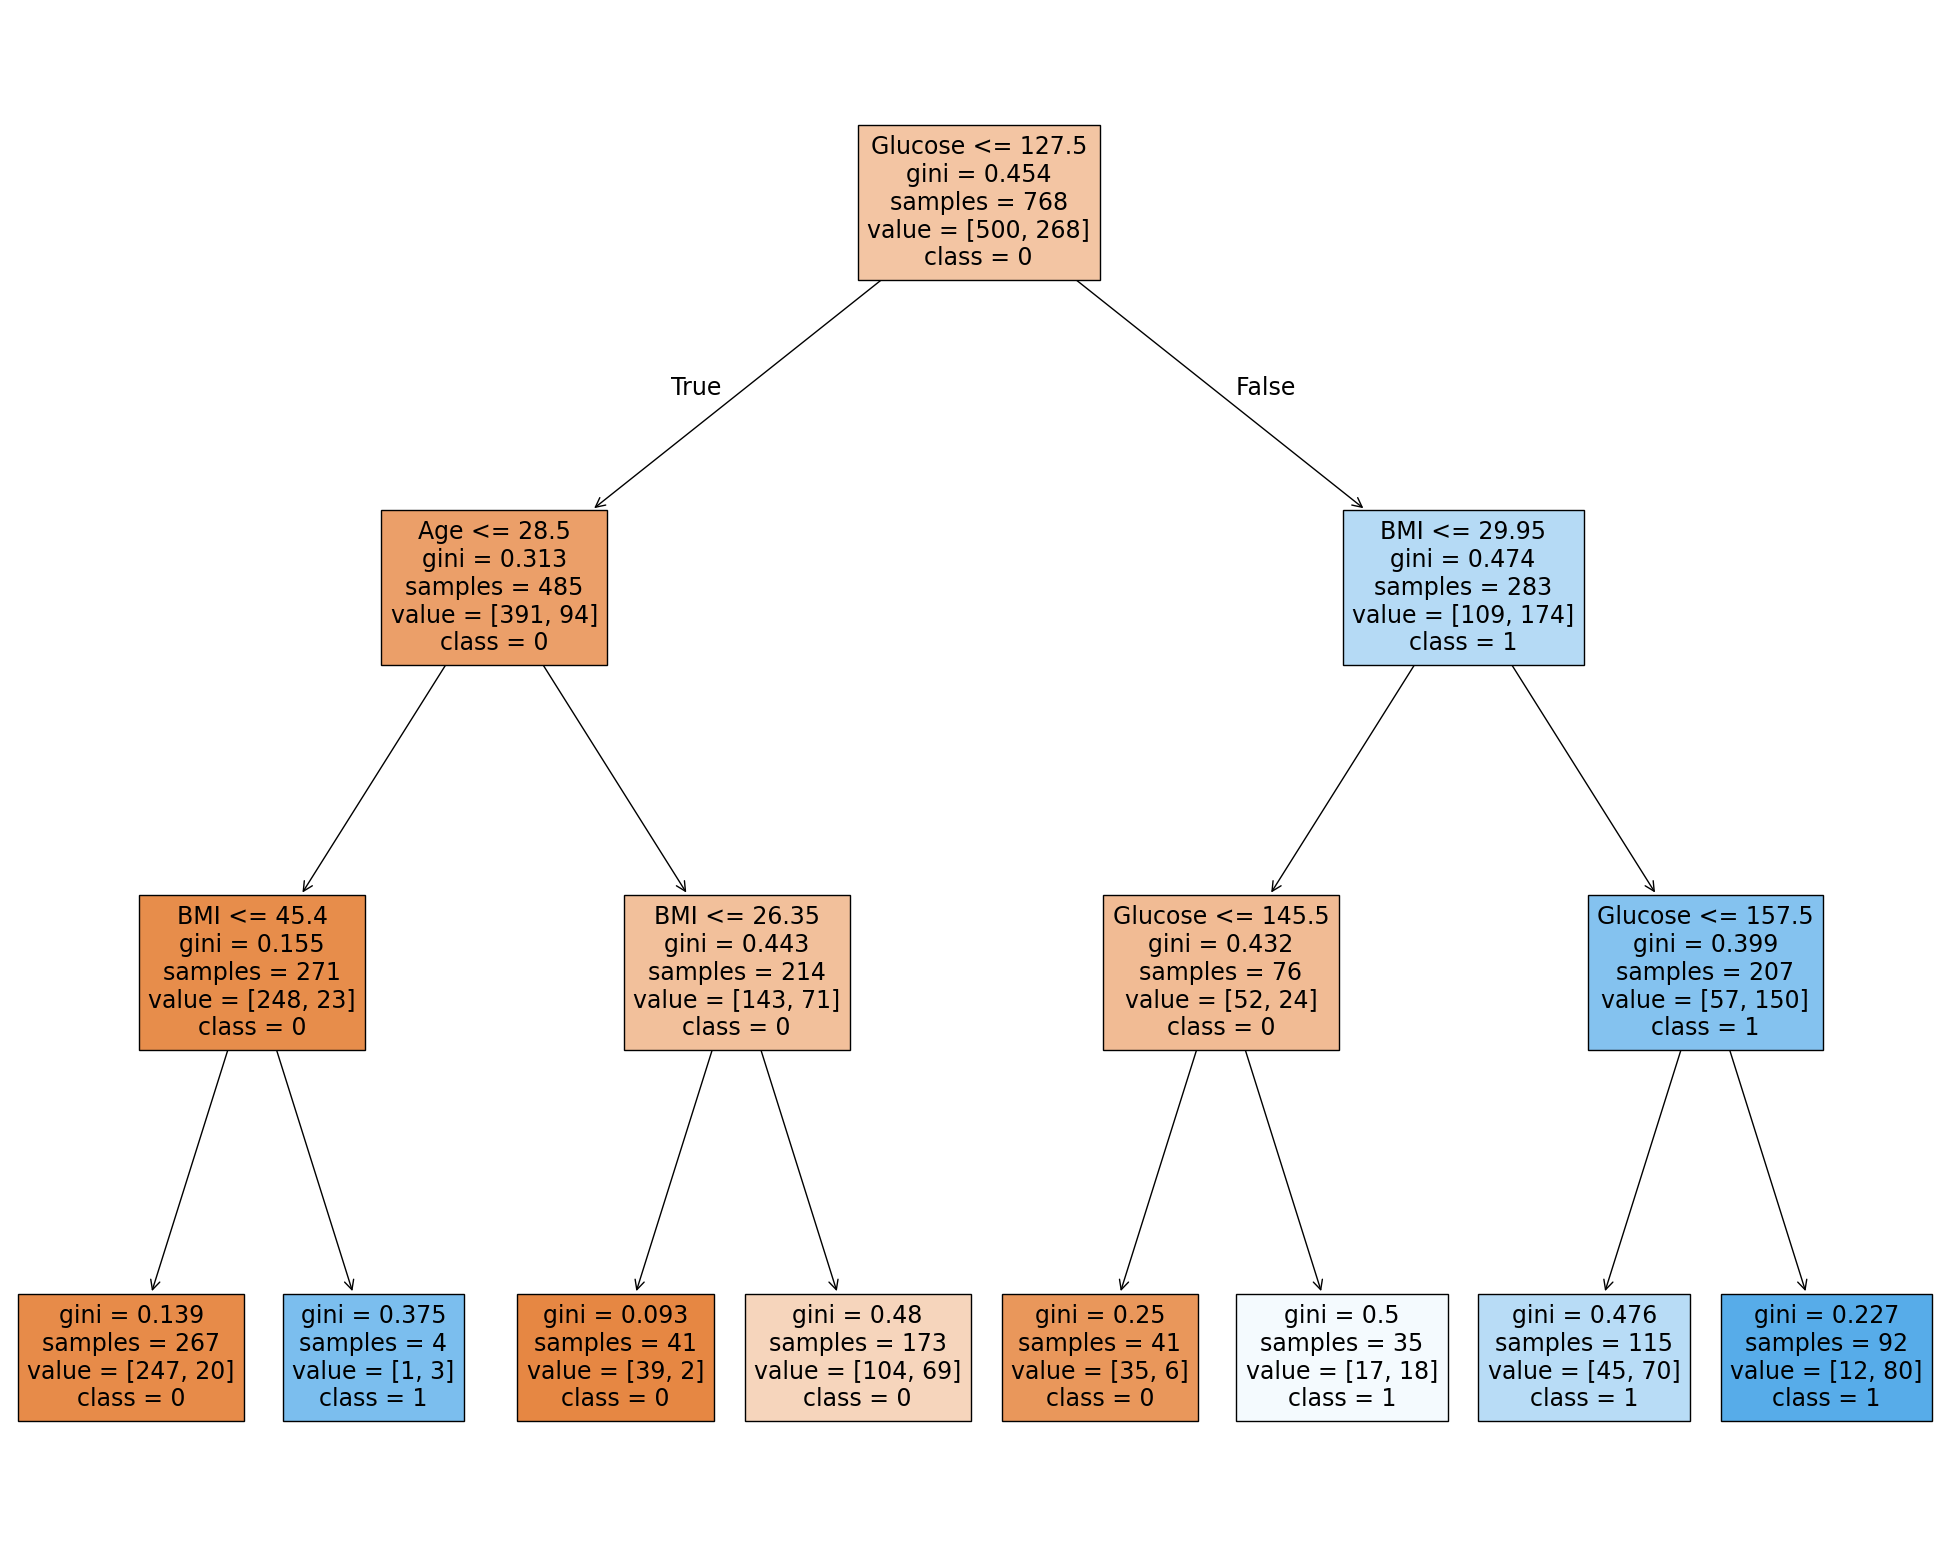

In [89]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(classifier, filled=True, feature_names=df.columns[:-1], class_names=['0', '1'])

#### ii. Explain what characterizes diabetes by identifying the conditional associations together with their posterior probabilities.

1. Individuals with diabetes have glucose levels above 127.5.
$$P(\text{having diabetes}|\text{Glucose}\gt 127.5) = 61,48\%$$

2. Individuals with diabetes have BMIs above 29.95.
$$P(\text{having diabetes}|\text{BMI}\gt 29.95) = 72,46\%$$

3. Individuals 